# Task 1
### Based on the data provied, describe the customers of the shops A, B, and C respectively. You are encouraged to utilize some visualization tools to represent the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

%matplotlib inline

plt.style.use('seaborn')

/home/saa2/pytorch_new/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


First lets take a look at the data presented

In [2]:
data = pd.read_excel('../data/rakuten_user_data.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
user_id                  1048575 non-null int64
gender                   1048575 non-null int64
user_age                 1045462 non-null float64
area_code                1046295 non-null float64
marital_flg              1048575 non-null int64
children_flg             1048575 non-null int64
lifetime_purchase_amt    983334 non-null float64
lifetime_purchase_cnt    983334 non-null float64
login_cnt_1m             1047793 non-null float64
login_cnt_3m             1047793 non-null float64
login_cnt_6m             1047793 non-null float64
shop_a_flg               1048575 non-null int64
shop_b_flg               1048575 non-null int64
shop_c_flg               1048575 non-null int64
dtypes: float64(7), int64(7)
memory usage: 112.0 MB


In [4]:
data.head()

,user_id,gender,user_age,area_code,marital_flg,children_flg,lifetime_purchase_amt,lifetime_purchase_cnt,login_cnt_1m,login_cnt_3m,login_cnt_6m,shop_a_flg,shop_b_flg,shop_c_flg
0,0,2,57.0,22.0,1,1,3800.0,297.0,32.0,90.0,188.0,1,0,0
1,1,2,54.0,13.0,0,0,92836.0,2409.0,38.0,103.0,246.0,0,1,0
2,2,2,42.0,20.0,2,2,90282.0,1786.0,59.0,160.0,284.0,1,0,0
3,3,1,55.0,26.0,1,1,151439.0,2984.0,35.0,146.0,342.0,0,1,0
4,4,2,55.0,13.0,1,1,101005.0,2728.0,103.0,418.0,824.0,0,1,0


## Handling Missing Values

The following is a visualization of the missing values in the dataset:

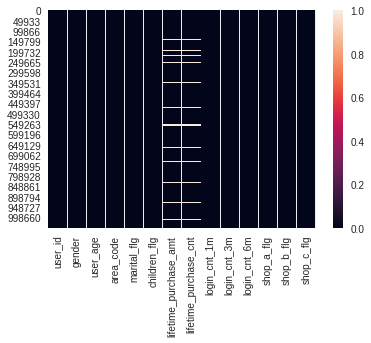

In [5]:
sns.heatmap(data.isnull())

From the visualization, it seems that the amount of missing values contributes to a very small percentage of the data presented. From this, it makes sense to apply simple heuristics to replace the missing values. We proceed to replace the missing values with the mean value of the dataset

In [6]:
data.fillna(data.mean(), inplace = True)

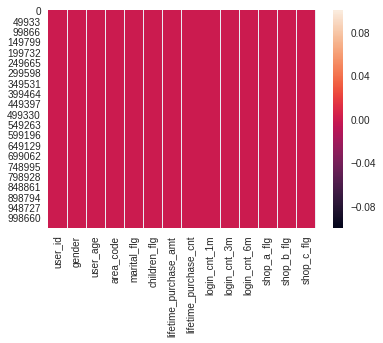

In [7]:
sns.heatmap(data.isnull())

From the visualization, we verify that we handled the missing valued accordingly using the above script

Lets do some thorough observations of the data presented.

In [8]:
cust_A = data[data['shop_a_flg'] == 1]
cust_B = data[data['shop_b_flg'] == 1]
cust_C = data[data['shop_c_flg'] == 1]

def categorize(row):
    if row['shop_a_flg'] == 1:
        return 'A'
    if row['shop_b_flg'] == 1:
        return 'B'
    if row['shop_c_flg'] == 1:
        return 'C'
        

data['shop'] = data.apply(categorize, axis = 1)

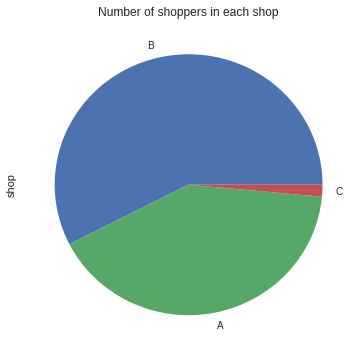

Number of people shopping in customer A is 50956
Number of people shopping in customer B is 71518
Number of people shopping in customer C is 1824


In [9]:
plt.figure(figsize = (6, 6))
data['shop'].value_counts().plot(kind = 'pie')

plt.title("Number of shoppers in each shop")

plt.show()

print("Number of people shopping in customer A is {}".format(len(cust_A)))
print("Number of people shopping in customer B is {}".format(len(cust_B)))
print("Number of people shopping in customer C is {}".format(len(cust_C)))

data.drop('shop', axis = 1, inplace = True)

We observe that C has the least number of customers

In [10]:
targets = ['shop_a_flg', 'shop_b_flg', 'shop_c_flg']
shops = ['A', 'B', 'C']
features = [x for x in data.columns if x not in targets]

The following is a script to generate all visualizations of the features in the data and the resulting visualization. From this, we can have a high level understanding of the data

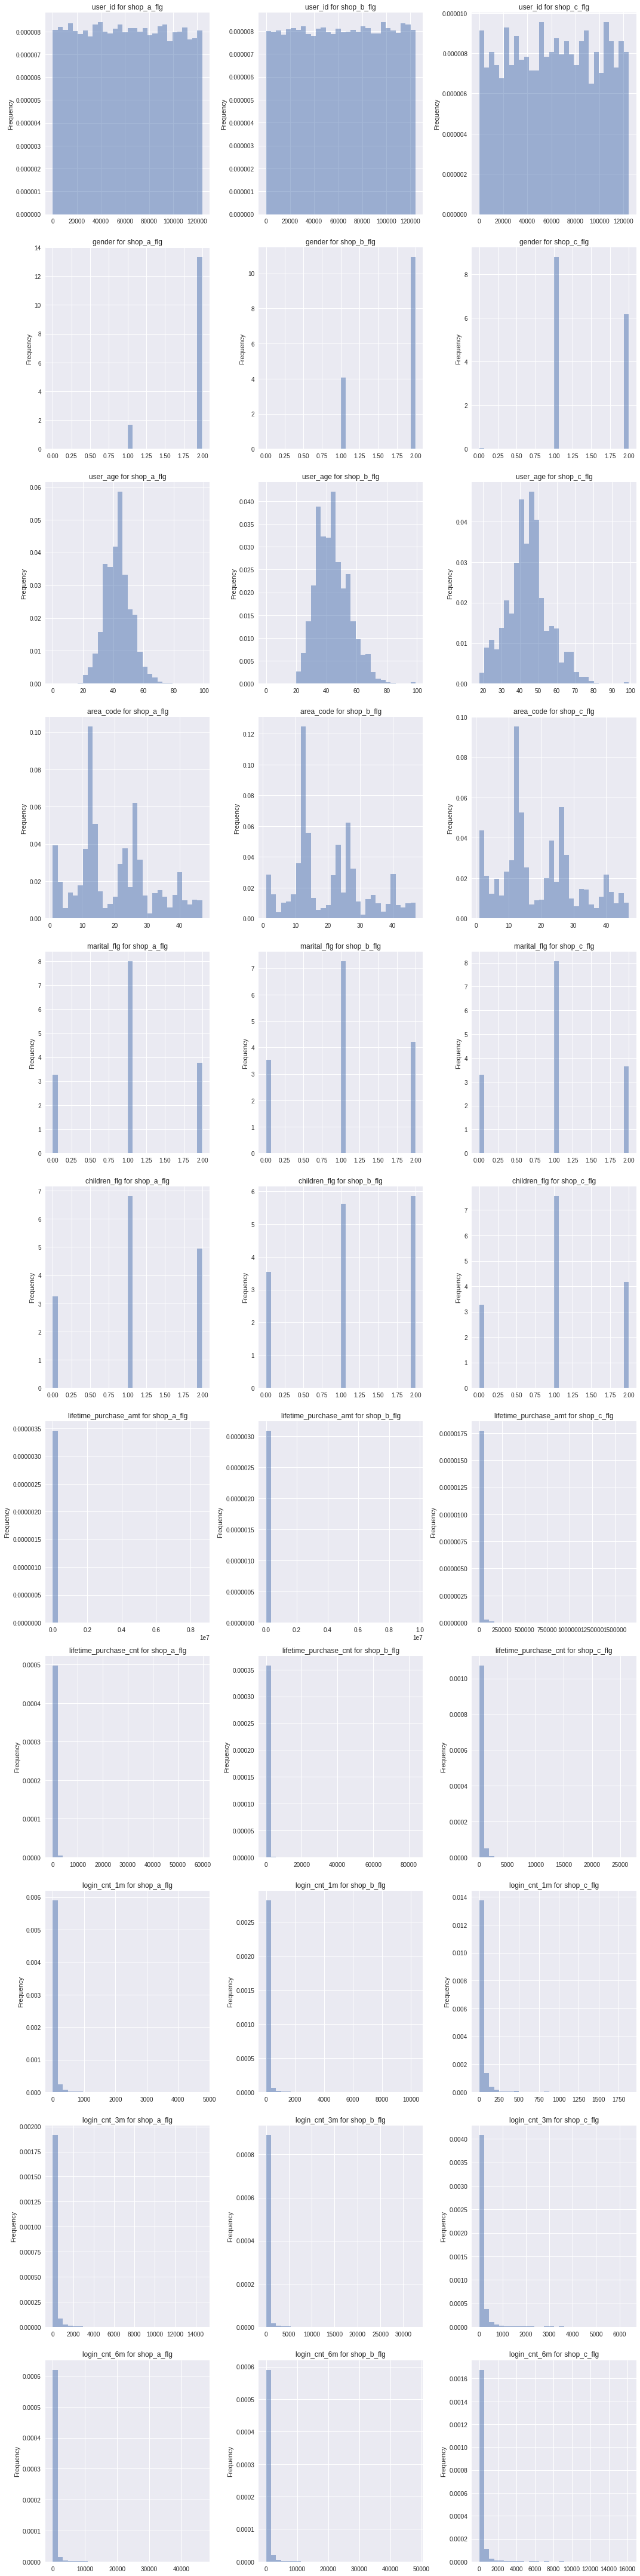

In [11]:
n_rows = len(features)
n_cols = len(targets)

fig, ax = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(15, 60))

for i, col in enumerate(features):
    
    for j in range(n_cols):
        which_shop = targets[j]
        temp = ax[i][j]
        data[data[which_shop] == 1][col].plot(kind='hist', ax=temp, alpha=0.5,  density = True, bins = 30)
        
        temp.set_title('{} for {}'.format(col, which_shop))
        
plt.tight_layout()

Lets dissect the features in a more thorough manner:

## Gender Distribution

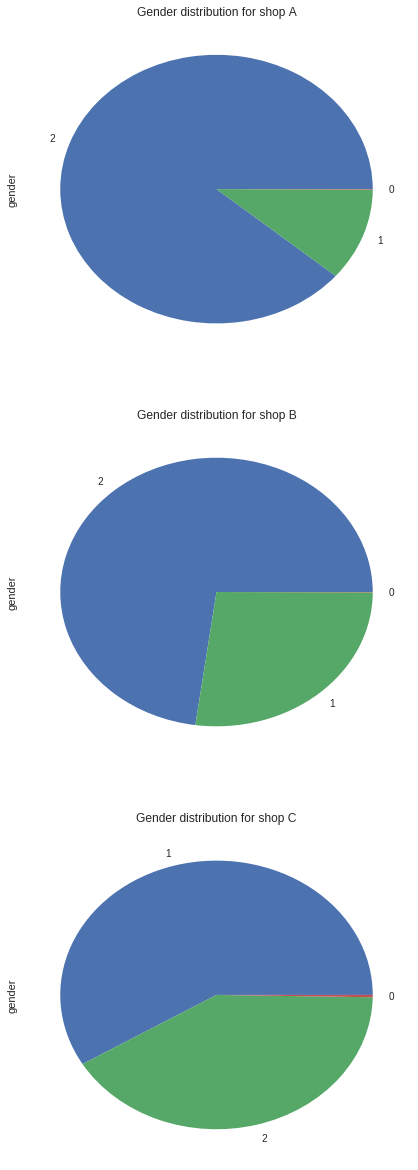

In [12]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (7, 21))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['gender'].value_counts().plot(kind='pie', ax=temp)
    
    temp.set_title("Gender distribution for shop {}".format(shops[i]))


#### *From the generated visualization. Shop A has the least number of male customers, followed by shop B and C. Shop C has a roughly balanced gender distribution*

## Age Distribution

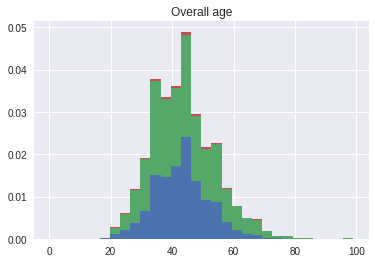

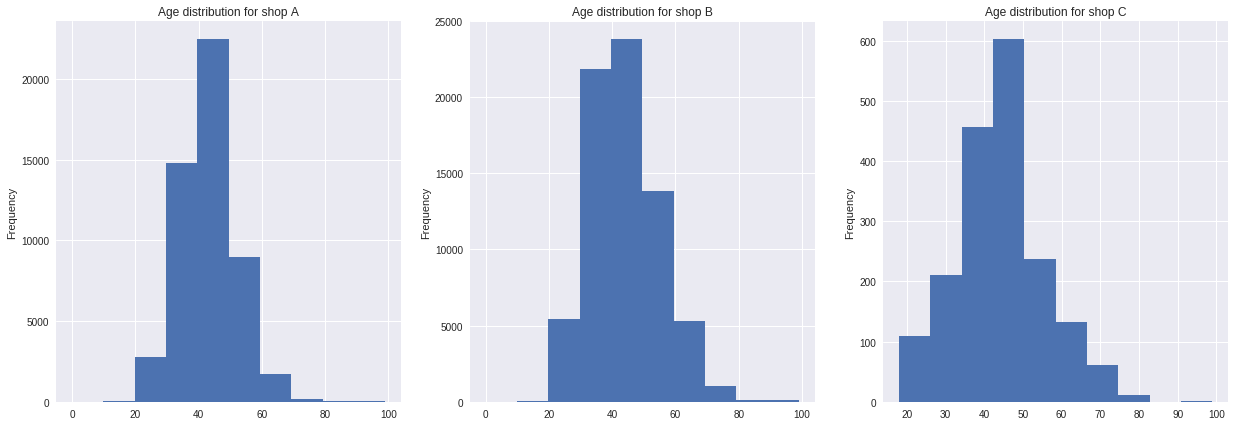

In [13]:
plt.figure()
plt.hist([cust_A['user_age'],cust_B['user_age'],cust_C['user_age']], bins = 30, stacked=True, density = True)
plt.title('Overall age')
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['user_age'].plot(kind='hist', ax=temp, density = False)
    
    temp.set_title("Age distribution for shop {}".format(shops[i]))


#### *There seems to be no noticeable differences between the age distribution for different shops, Lets proceed to verify that:*

In [14]:
print("The mean age of customers in shop A is {} , std {}".format(cust_A.describe()['user_age']['mean'], cust_A.describe()['user_age']['std']))
print("The mean age of customers in shop B is {} , std {}".format(cust_B.describe()['user_age']['mean'], cust_B.describe()['user_age']['std']))
print("The mean age of customers in shop C is {} , std {}".format(cust_C.describe()['user_age']['mean'], cust_C.describe()['user_age']['std']))

The mean age of customers in shop A is 43.07222033548318 , std 8.909831700902217
The mean age of customers in shop B is 43.938373494661924 , std 11.086819475932552
The mean age of customers in shop C is 44.4390654027396 , std 11.213201462902806


## Area Code

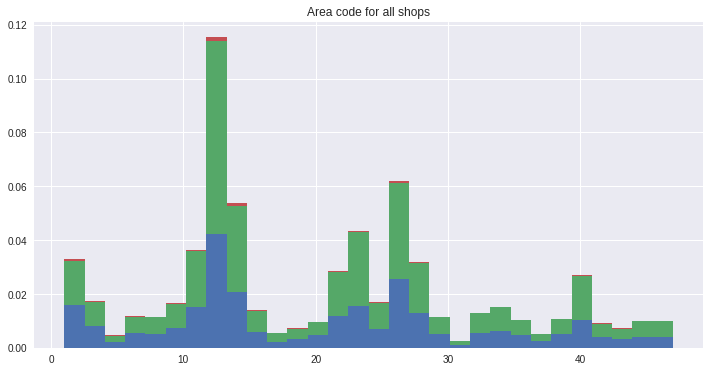

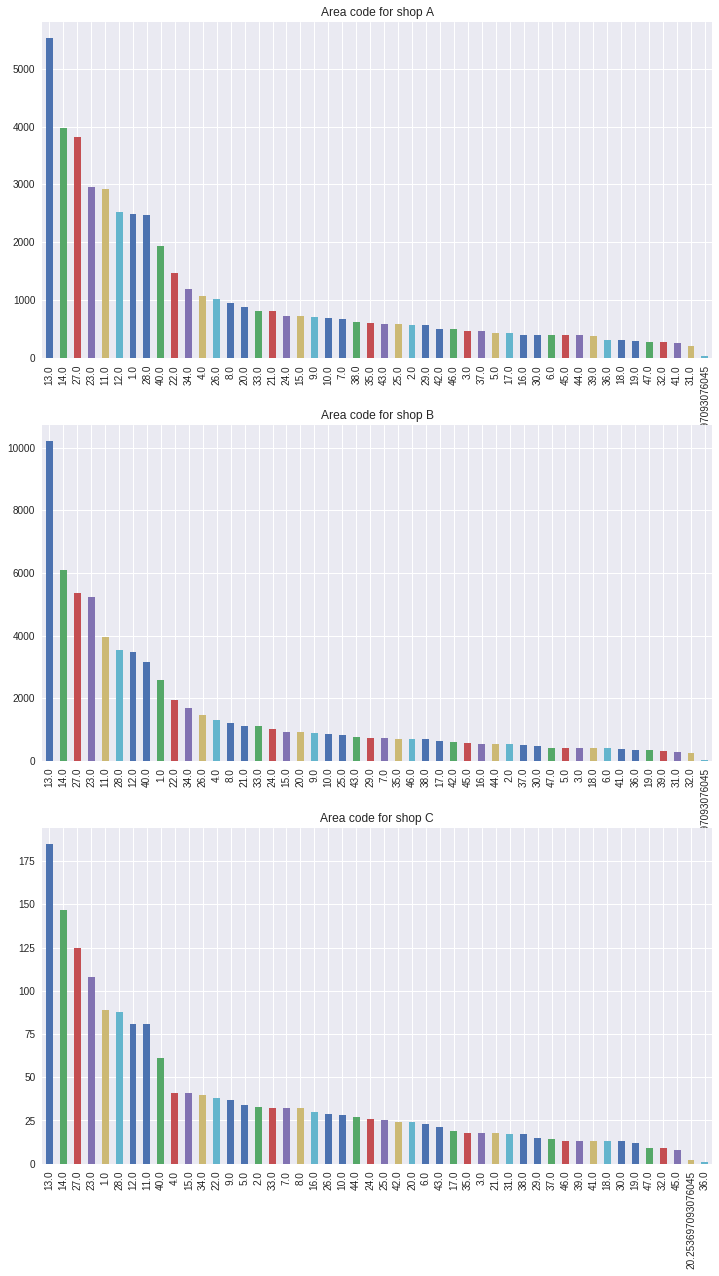

In [15]:
n_bins = cust_A['area_code'].nunique()

plt.figure(figsize = (12, 6))
plt.hist([cust_A['area_code'],cust_B['area_code'],cust_C['area_code']], bins = 30, stacked=True, density = True)
plt.title('Area code for all shops')

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (12, 21))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['area_code'].value_counts().plot(kind='bar', ax=temp)
    
    temp.set_title("Area code for shop {}".format(shops[i]))

#### *No noticeable differences can be observed for the feature area code from the generated visualization, Area code 13 seems to generate the most traffic for these shops, followed by 14 and 27*

## Marriage Status

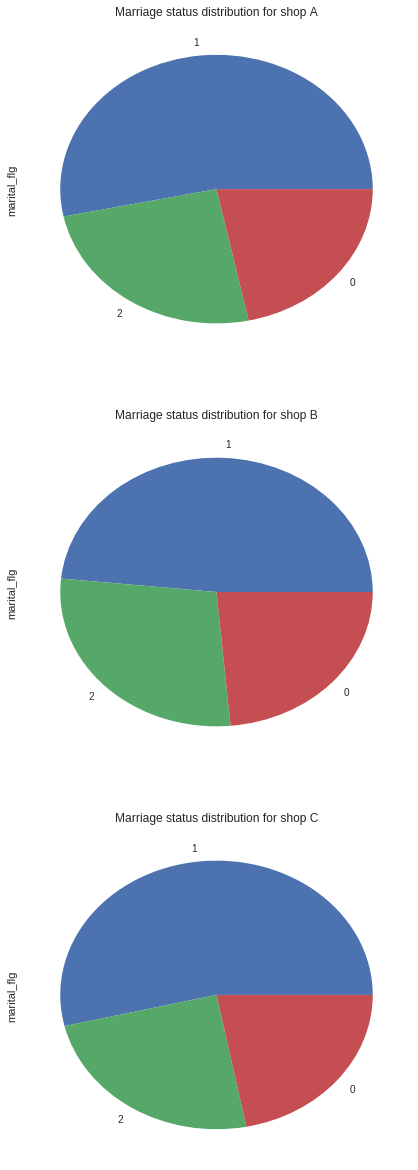

In [16]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (7, 21))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['marital_flg'].value_counts().plot(kind='pie', ax=temp)
    
    temp.set_title("Marriage status distribution for shop {}".format(shops[i]))


#### *Once again, no noticeable differences for each shops. Marriage status '1' (Single) seems to be the dominant category in this feature consistent for different shops*

## Children Ownership

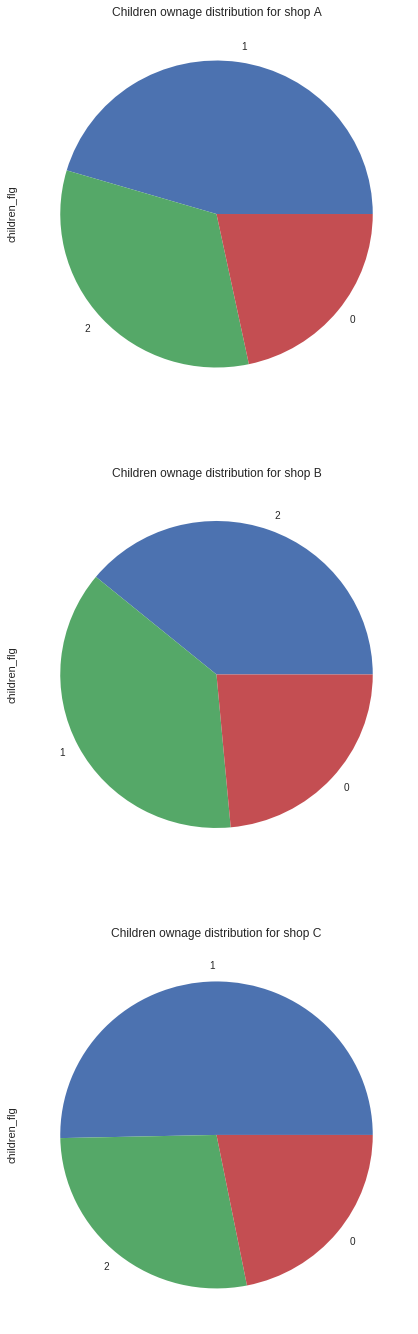

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (7, 24))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['children_flg'].value_counts().plot(kind='pie', ax=temp)
    
    temp.set_title("Children ownage distribution for shop {}".format(shops[i]))

#### *Generally, category '1' (Have Children) is the most dominant cateogry. Shop A and C have similar distrbutions for children ownage with 1 ('Have Chilldren') being the most dominant category. While shop B has a roughly balanced distribution*

## Purchase Amount and Login Count

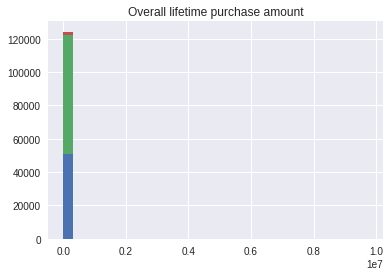

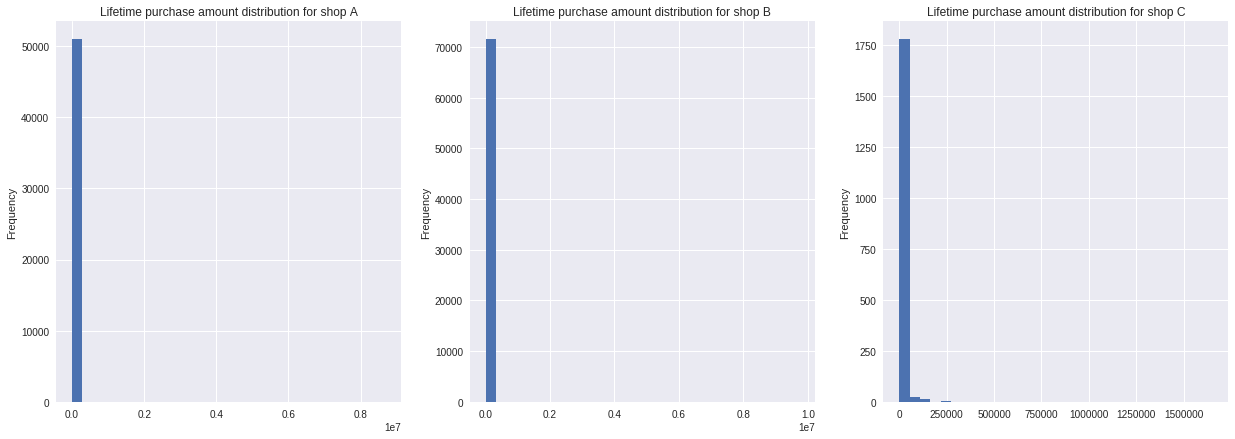

In [18]:
plt.figure()
plt.hist([cust_A['lifetime_purchase_amt'],cust_B['lifetime_purchase_amt'],cust_C['lifetime_purchase_amt']], bins = 30, stacked=True, density = False)
plt.title('Overall lifetime purchase amount')

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['lifetime_purchase_amt'].plot(kind='hist', ax=temp, bins = 30)
    
    temp.set_title("Lifetime purchase amount distribution for shop {}".format(shops[i]))

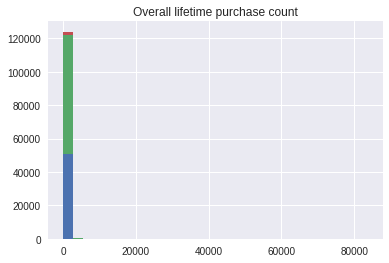

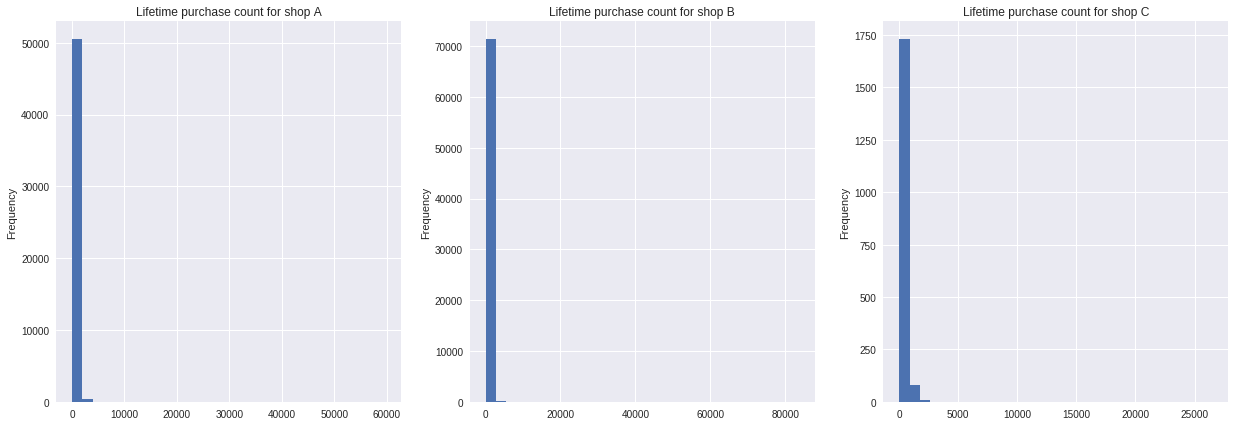

In [19]:
plt.figure()
plt.hist([cust_A['lifetime_purchase_cnt'],cust_B['lifetime_purchase_cnt'],cust_C['lifetime_purchase_cnt']], bins = 30, stacked=True, density = False)
plt.title('Overall lifetime purchase count')

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['lifetime_purchase_cnt'].plot(kind='hist', ax=temp, bins = 30)
    
    temp.set_title("Lifetime purchase count for shop {}".format(shops[i]))

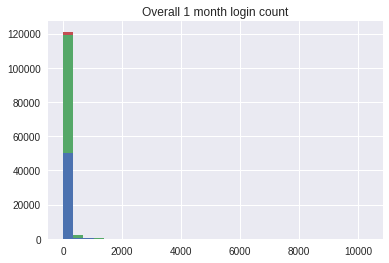

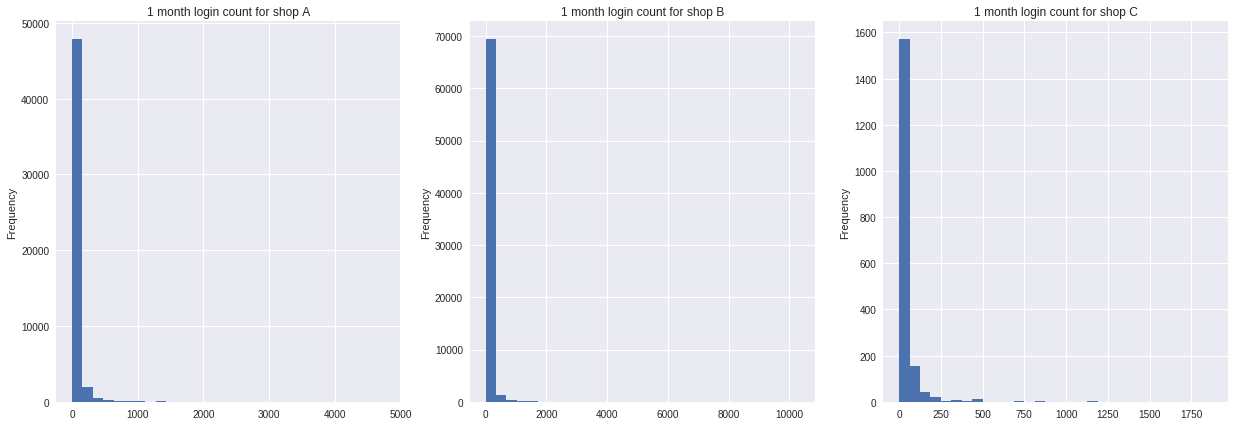

In [20]:
plt.figure()
plt.hist([cust_A['login_cnt_1m'],cust_B['login_cnt_1m'],cust_C['login_cnt_1m']], bins = 30, stacked=True, density = False)
plt.title('Overall 1 month login count')

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['login_cnt_1m'].plot(kind='hist', ax=temp, bins = 30)
    
    temp.set_title("1 month login count for shop {}".format(shops[i]))

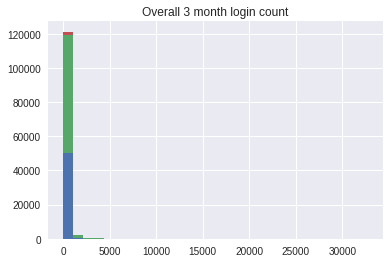

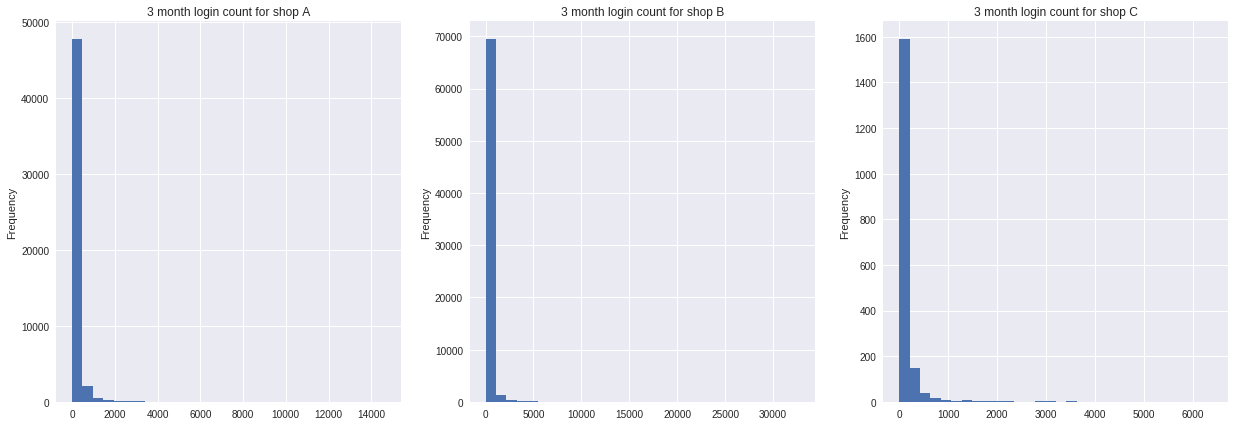

In [21]:
plt.figure()
plt.hist([cust_A['login_cnt_3m'],cust_B['login_cnt_3m'],cust_C['login_cnt_3m']], bins = 30, stacked=True, density = False)
plt.title('Overall 3 month login count')

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['login_cnt_3m'].plot(kind='hist', ax=temp, bins = 30)
    
    temp.set_title("3 month login count for shop {}".format(shops[i]))

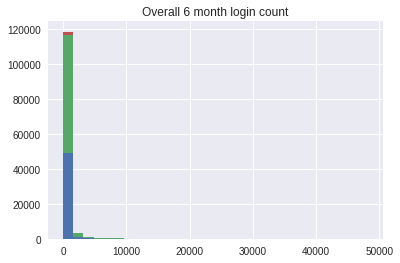

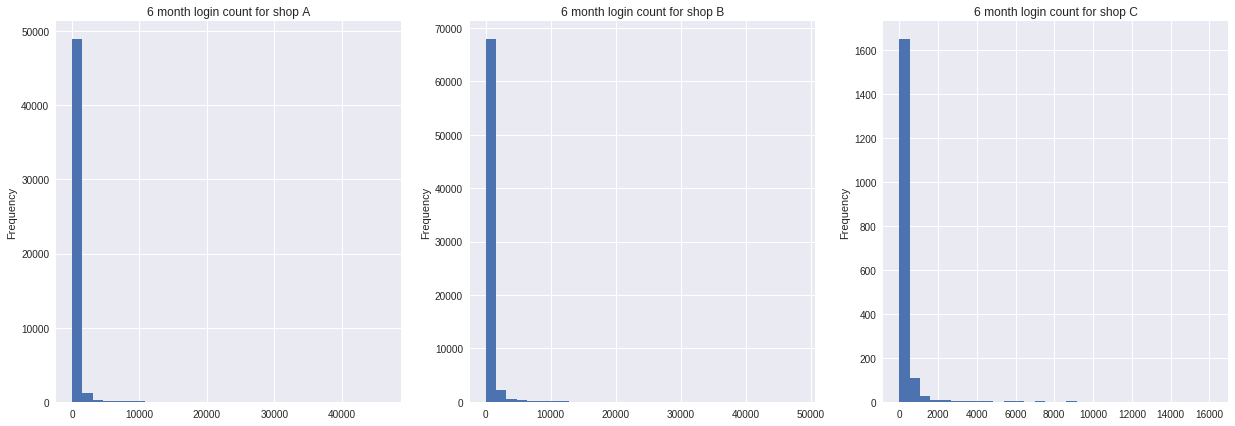

In [22]:
plt.figure()
plt.hist([cust_A['login_cnt_6m'],cust_B['login_cnt_6m'],cust_C['login_cnt_6m']], bins = 30, stacked=True, density = False)
plt.title('Overall 6 month login count')

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 7))

for i in range(len(ax)):
    temp = ax[i]
    shop = targets[i]
    
    data[data[shop] == 1]['login_cnt_6m'].plot(kind='hist', ax=temp, bins = 30)
    
    temp.set_title("6 month login count for shop {}".format(shops[i]))

#### *It is with sufficient evidence to conclude that Shop C attracts more active customers compared to Shop A and B. Shown by Shop C's customers' lifetime purchase amount and the login count of the which has a slightly more right centered distribution compared to A and B.*